# <div style="font-family: Arial; font-size: 24px; text-align: center;">Volume Forecasing for VirtualCare@UHN</div>


# Part: W/M-ly VC Volume Prediction + Features: PSA (w/ calls)

## Information


- **Title:** VC Volume Forecasting for VirtualCare@UNH
- **Version:** 2.0
- **Date:**  17/10/23
- **Author:**

## Version History

|Version|Descriptions|Date|
|-------|------------|----|
|v0.0|PSA encoding |06/10/23|
|v1.0|Feature Merging      |07/10/23|
|v2.0|LSTM Modelling    |14/09/23|

## Installation

In [1]:
# !pip install tensorflow

## Libraries

In [2]:
import sys
from google.colab import drive
import datetime

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, MultiHeadAttention, Flatten, Input

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import MeanAbsoluteError

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, MultiHeadAttention, Flatten, Input, Dense, Dropout

from keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


## Loading

In [3]:
drive.mount('/content/gdrive')
# To custome your directory
path_data = '/content/gdrive/MyDrive/DHDA/2023/DHPO_PLAN/'
path_utility = '/content/gdrive/MyDrive/DHDA/2023/DHPO_CODE/'

sys.path.append(path_data)
sys.path.append(path_utility)

Mounted at /content/gdrive


In [4]:
# Defined methods imported
import utils_lstm_psa as ulp

In [5]:
# Loading data
file_path = path_data + 'MERGED_VC_DATA_012.csv'
is_file_opened = False

while not is_file_opened:
    try:
        df = pd.read_csv(file_path, parse_dates=['Appt_Start_Time'])
        is_file_opened = True
    except FileNotFoundError:
        print("File not found. Please provide the correct file path.")
        file_path = input("Enter the file path: ")

## Data Preparation

### Initial Processing

In [6]:
# Convert column names to lowercase to ensure consistency
df.columns = df.columns.str.lower()
# Replace any spaces in column names with underscores for easier referencing
df.columns = df.columns.str.replace(' ', '_')

# Convert all string values to lowercase and replace hyphens with underscores
# This lambda function checks if the value is a string, and if so, performs the replacements
df = df.applymap(lambda x: x.lower().replace('-', '_') if type(x) == str else x)
df = df.applymap(lambda x: x.lower().replace(' ', '_') if type(x) == str else x)

In [7]:
print(df.info())
print('\n')
print(f"Raw data's shape:{df.shape}")
print('\n')
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2150366 entries, 0 to 2150365
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   appt_start_time        datetime64[ns]
 1   appt_status            object        
 2   appt_reschedule_time   object        
 3   appt_type              object        
 4   care_modality          object        
 5   cleaned_visit_number   int64         
 6   cleaned_patient_id     int64         
 7   cleaned_provider_id    float64       
 8   cleaned_location_name  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 147.7+ MB
None


Raw data's shape:(2150366, 9)




,appt_start_time,appt_status,appt_reschedule_time,appt_type,care_modality,cleaned_visit_number,cleaned_patient_id,cleaned_provider_id,cleaned_location_name
0,2022-08-01 04:30:00,canceled,NaN,other,face_to_face,255140,137472,2145.0,location_205
1,2022-08-01 07:15:00,completed,NaN,other,face_to_face,226840,20289,1270.0,location_209
2,2022-08-01 07:15:00,completed,NaN,other,face_to_face,244131,14378,1278.0,location_209
3,2022-08-01 07:15:00,completed,NaN,other,face_to_face,244392,48707,1383.0,location_209
4,2022-08-01 07:15:00,completed,NaN,other,face_to_face,245314,901,1185.0,location_209


#### Service Validation

In [8]:
# Filter out appointments that were not completed
completed_appointments = df[df['appt_status'] == 'completed']
completed_appointments.head(5)

,appt_start_time,appt_status,appt_reschedule_time,appt_type,care_modality,cleaned_visit_number,cleaned_patient_id,cleaned_provider_id,cleaned_location_name
1,2022-08-01 07:15:00,completed,NaN,other,face_to_face,226840,20289,1270.0,location_209
2,2022-08-01 07:15:00,completed,NaN,other,face_to_face,244131,14378,1278.0,location_209
3,2022-08-01 07:15:00,completed,NaN,other,face_to_face,244392,48707,1383.0,location_209
4,2022-08-01 07:15:00,completed,NaN,other,face_to_face,245314,901,1185.0,location_209
5,2022-08-01 07:15:00,completed,NaN,other,face_to_face,258939,138386,1438.0,location_209


#### OneHot for Modalities

In [9]:
modalities = pd.get_dummies(completed_appointments['care_modality'])
completed_appointments = pd.concat([completed_appointments, modalities], axis=1)

completed_appointments.set_index('appt_start_time', inplace=True)
completed_appointments

,appt_status,appt_reschedule_time,appt_type,care_modality,cleaned_visit_number,cleaned_patient_id,cleaned_provider_id,cleaned_location_name,face_to_face,ms_teams,phone,telehealth
appt_start_time,,,,,,,,,,,,
2022-08-01 07:15:00,completed,NaN,other,face_to_face,226840,20289,1270.0,location_209,1,0,0,0
2022-08-01 07:15:00,completed,NaN,other,face_to_face,244131,14378,1278.0,location_209,1,0,0,0
2022-08-01 07:15:00,completed,NaN,other,face_to_face,244392,48707,1383.0,location_209,1,0,0,0
2022-08-01 07:15:00,completed,NaN,other,face_to_face,245314,901,1185.0,location_209,1,0,0,0
2022-08-01 07:15:00,completed,NaN,other,face_to_face,258939,138386,1438.0,location_209,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 18:00:00,completed,NaN,other,face_to_face,1566165,84625,2289.0,location_246,1,0,0,0
2023-08-31 18:00:00,completed,NaN,other,face_to_face,1566049,130812,2181.0,location_246,1,0,0,0
2023-08-31 18:00:00,completed,NaN,other,face_to_face,1566046,240068,1451.0,location_246,1,0,0,0


#### Wrangling

In [10]:
# List of columns to delete
columns_to_delete = ['appt_status','appt_reschedule_time','appt_type','care_modality',
                     'cleaned_visit_number','cleaned_location_name']

# Drop the columns
completed_appointments = completed_appointments.drop(columns=columns_to_delete)
completed_appointments.head(5)

,cleaned_patient_id,cleaned_provider_id,face_to_face,ms_teams,phone,telehealth
appt_start_time,,,,,,
2022-08-01 07:15:00,20289,1270.0,1,0,0,0
2022-08-01 07:15:00,14378,1278.0,1,0,0,0
2022-08-01 07:15:00,48707,1383.0,1,0,0,0
2022-08-01 07:15:00,901,1185.0,1,0,0,0
2022-08-01 07:15:00,138386,1438.0,1,0,0,0


### Resample

In [11]:
# Defined method calls
daily_data = ulp.aggregate_data(completed_appointments, 'D')
weekly_data = ulp.aggregate_data(completed_appointments, 'W')
monthly_data = ulp.aggregate_data(completed_appointments, 'M')

# Display the first few rows of the weekly data as an example
print(weekly_data.head())

                 face_to_face  ms_teams  phone  telehealth  total    vc  \
appt_start_time                                                           
2022-08-07              12916      1060   3734         261  17971  5055   
2022-08-14              16422      1402   5316         300  23440  7018   
2022-08-21              16267      1344   5597         279  23487  7220   
2022-08-28              14890      1464   5053         226  21633  6743   
2022-09-04              15337      1389   4820         220  21766  6429   

                  vc_prop  pt_vc_nb  pr_vc_nb  pt_nb  pr_nb  
appt_start_time                                              
2022-08-07       0.281287      4674       636  13563   1371  
2022-08-14       0.299403      6485       716  17656   1487  
2022-08-21       0.307404      6711       725  17842   1485  
2022-08-28       0.311700      6209       707  16418   1415  
2022-09-04       0.295369      5937       709  16380   1452  


### Visualization

#### Care Modality Volumes

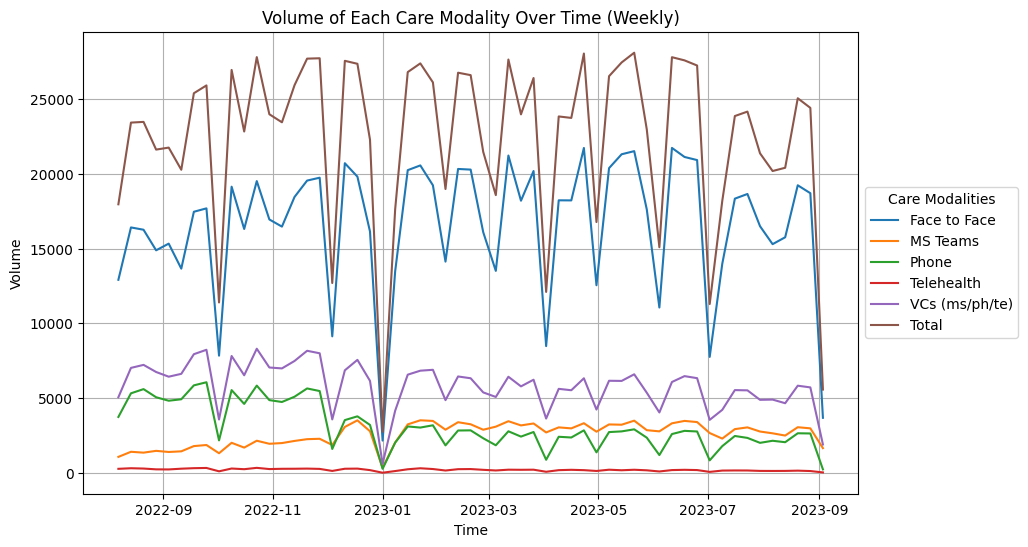

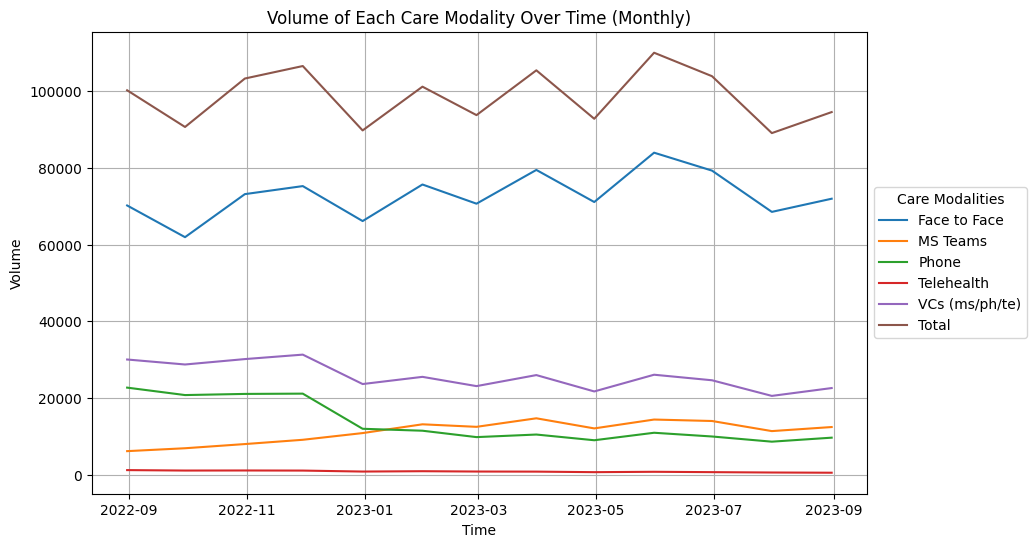

In [12]:
# Defined method calls
ulp.plot_care_modalities(weekly_data, title_suffix='Weekly')
ulp.plot_care_modalities(monthly_data, title_suffix='Monthly')

#### Providers vs Patients

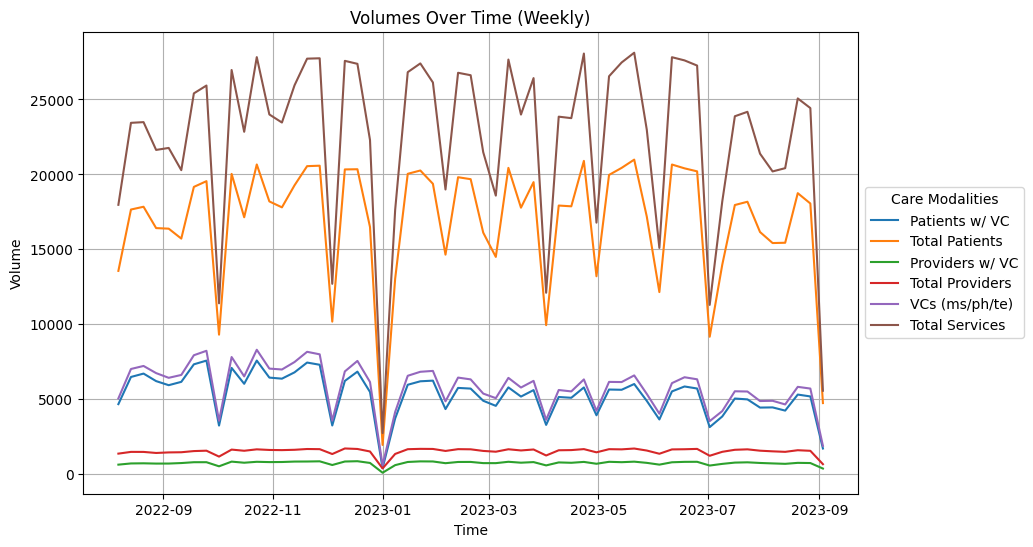

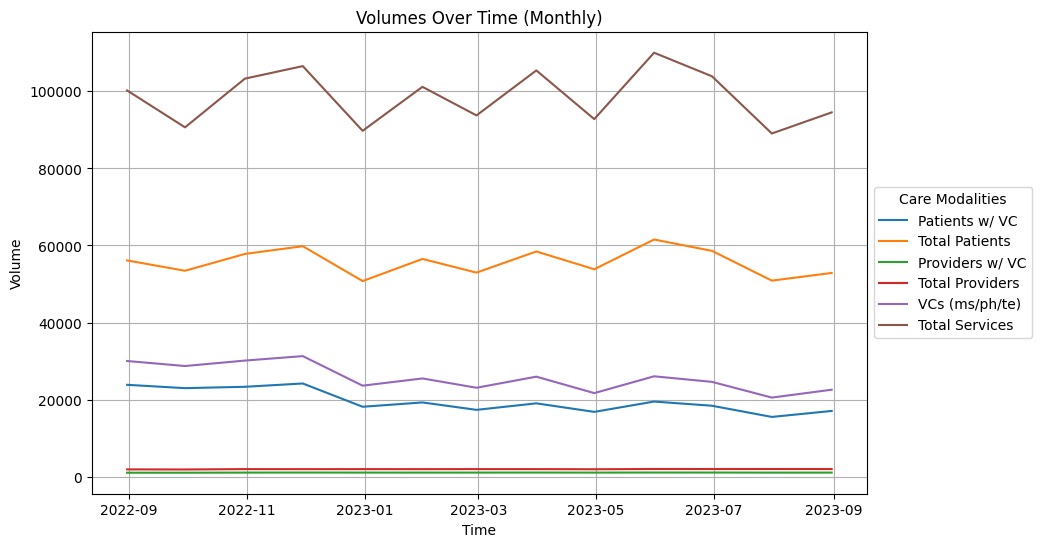

In [13]:
# Defined method calls
ulp.plot_volumes_over_time(weekly_data, title_suffix='Weekly')
ulp.plot_volumes_over_time(monthly_data, title_suffix='Monthly')

#### Stacked Bar of Modalites

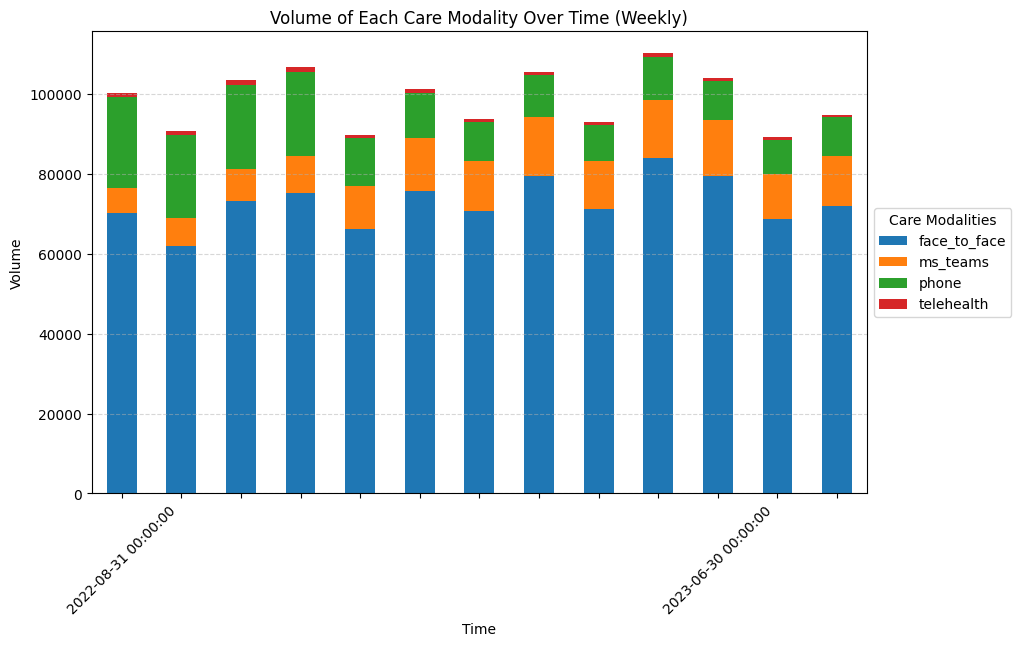

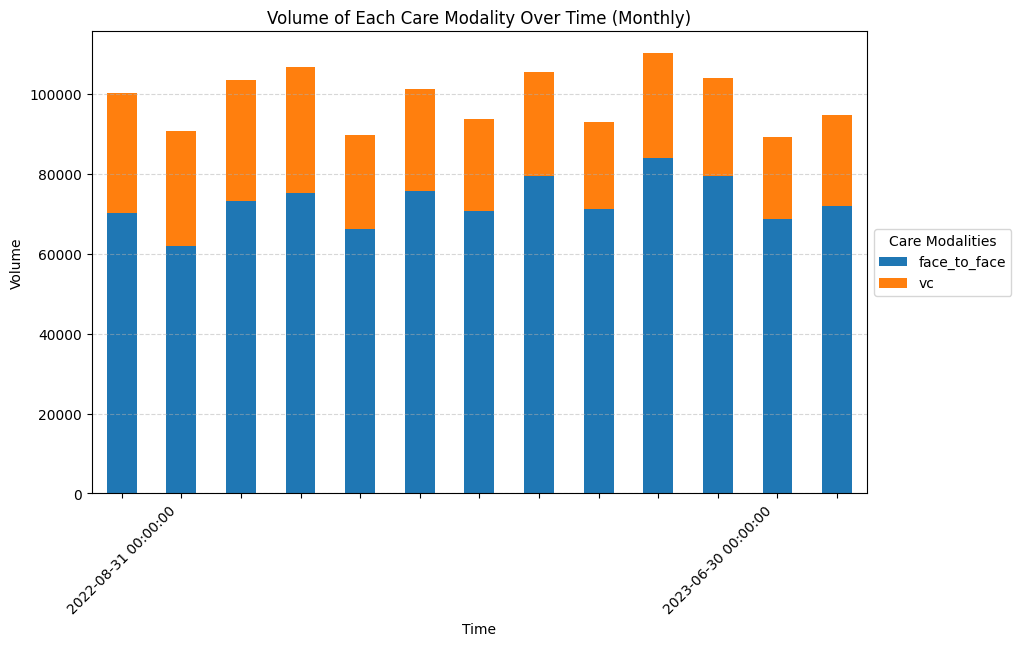

In [14]:
# Defined method calls
ulp.bar_plot(monthly_data, list(range(0,4)), 'Volume of Each Care Modality Over Time (Weekly)')
ulp.bar_plot(monthly_data, [0,5], 'Volume of Each Care Modality Over Time (Monthly)')

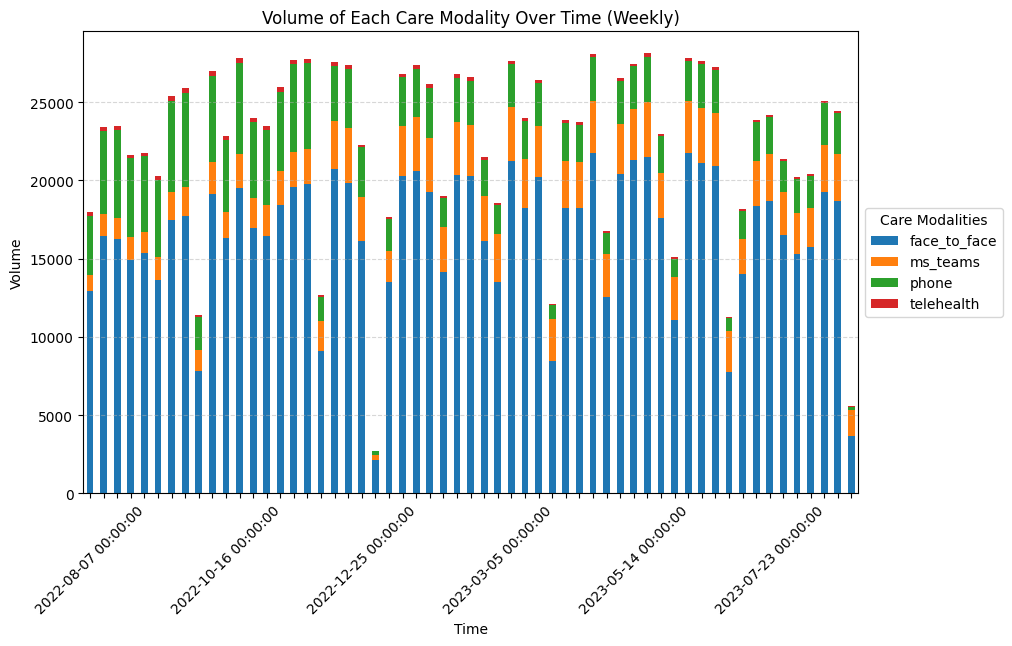

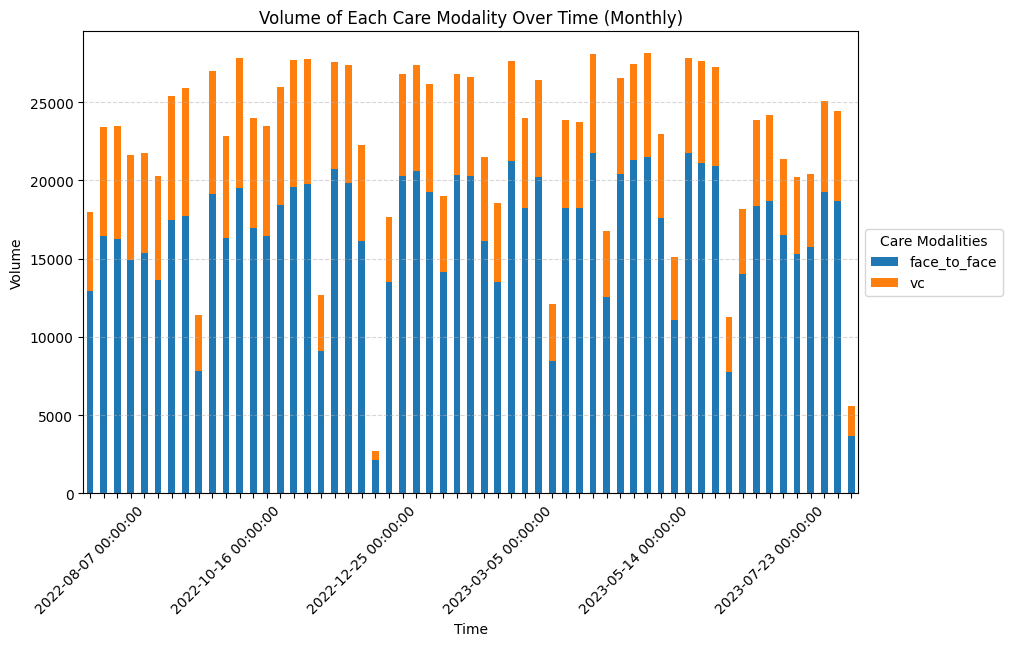

In [15]:
# Defined method calls
ulp.bar_plot(weekly_data, list(range(0,4)), 'Volume of Each Care Modality Over Time (Weekly)')
ulp.bar_plot(weekly_data, [0,5], 'Volume of Each Care Modality Over Time (Monthly)')

### PSA

#### PSA Event Loading

#### Event Encoding

In [16]:
events = ["FHO Managed Entry 1", "FHO Managed Entry 2", "Compensation Increase 1", "Compensation Increase 2",
          "After Hours Requirements 1", "After Hours Requirements 2", "FHO Weekly Patient Access",
          "Virtual Care", "Preventive Care Bonus", "Fee-for-service Hard Cap", "Billing Submission"]
timestamps = ["2022-04-01", "2023-04-01", "2022-04-01", "2023-04-01", "2022-07-01", "2023-03-31",
              "2022-07-01", "2022-10-01", "2023-04-01", "2023-04-01", "2023-04-01"]
start_date = "2022-08-01"
end_date = "2023-08-31"

# Defined method calls
valid_events = ulp.create_event_dataframe(events, timestamps, start_date, end_date)
print(valid_events)

                     eventname  timestamp
1          fho_managed_entry_2 2023-04-01
3      compensation_increase_2 2023-04-01
5   after_hours_requirements_2 2023-03-31
7                 virtual_care 2022-10-01
8        preventive_care_bonus 2023-04-01
9     fee_for_service_hard_cap 2023-04-01
10          billing_submission 2023-04-01


#### PSA Merging

In [17]:
# Defined method calls
w_encoded_psa = ulp.encode_and_resample(valid_events, start_date, end_date, 'W-SUN')
m_encoded_psa = ulp.encode_and_resample(valid_events, start_date, end_date, 'M')

print("Weekly resampled shape:", w_encoded_psa.shape)
print("Monthly resampled shape:", m_encoded_psa.shape)

Weekly resampled shape: (57, 7)
Monthly resampled shape: (13, 7)


In [18]:
# Defined method calls
w_data_psa = pd.merge(weekly_data,  w_encoded_psa, left_index=True, right_index=True, how='left')
m_data_psa = pd.merge(monthly_data, m_encoded_psa, left_index=True, right_index=True, how='left')
# w_data_psa = w_data_psa.drop(columns=['vc_prop'])

print(f"Weekly data w/ PSA'shape: {w_data_psa.shape}")
print('\n')
print(f"Monthly data w/ PSA'shape: {m_data_psa.shape}")
print('\n')
print(w_data_psa.head(5))
print('\n')
print(m_data_psa.head(5))

Weekly data w/ PSA'shape: (57, 18)


Monthly data w/ PSA'shape: (13, 18)


                 face_to_face  ms_teams  phone  telehealth  total    vc  \
appt_start_time                                                           
2022-08-07              12916      1060   3734         261  17971  5055   
2022-08-14              16422      1402   5316         300  23440  7018   
2022-08-21              16267      1344   5597         279  23487  7220   
2022-08-28              14890      1464   5053         226  21633  6743   
2022-09-04              15337      1389   4820         220  21766  6429   

                  vc_prop  pt_vc_nb  pr_vc_nb  pt_nb  pr_nb  \
appt_start_time                                               
2022-08-07       0.281287      4674       636  13563   1371   
2022-08-14       0.299403      6485       716  17656   1487   
2022-08-21       0.307404      6711       725  17842   1485   
2022-08-28       0.311700      6209       707  16418   1415   
2022-09-04       0.29

## LSTM

### Feature Extraction

In [19]:
print(w_data_psa.info())
print('\n')
print(m_data_psa.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2022-08-07 to 2023-09-03
Freq: W-SUN
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   face_to_face                57 non-null     uint64 
 1   ms_teams                    57 non-null     uint64 
 2   phone                       57 non-null     uint64 
 3   telehealth                  57 non-null     uint64 
 4   total                       57 non-null     int64  
 5   vc                          57 non-null     int64  
 6   vc_prop                     57 non-null     float64
 7   pt_vc_nb                    57 non-null     int64  
 8   pr_vc_nb                    57 non-null     int64  
 9   pt_nb                       57 non-null     int64  
 10  pr_nb                       57 non-null     int64  
 11  fho_managed_entry_2         57 non-null     int64  
 12  compensation_increase_2     57 non-null     int64  
 13  after

### Run After: Feature Eng.

In [20]:
# Selection w/o PSA
feature_columns1 = ['face_to_face', 'ms_teams', 'phone', 'telehealth', 'total',
                   'pt_vc_nb', 'pt_nb', 'pr_vc_nb', 'pr_nb'  # pt:patients, nb:number, pr:provider
                   ]

# Selection w/ PSA
feature_columns2 = ['face_to_face', 'ms_teams', 'phone', 'telehealth', 'total',
                   'pt_vc_nb', 'pt_nb', 'pr_vc_nb', 'pr_nb',  # pt:patients, nb:number, pr:provider
                   'fho_managed_entry_2',                     # PSA events
                   'compensation_increase_2',
                   'after_hours_requirements_2',
                   'virtual_care',
                   'preventive_care_bonus',
                   'fee_for_service_hard_cap','billing_submission'
                   ]
# Options: 'vc', 'total', or other desired columns
target_column = 'vc' # virtual care volumes

#!# Choosing time granularity
data_type1 = weekly_data # options: monthly_data, weekly_data
data_type2 = w_data_psa # options: w_data_psa, m_data_psa

# Defined method calls
# features, target = ulp.get_features_and_target(data_type1, feature_columns1, target_column)
features, target = ulp.get_features_and_target(data_type2, feature_columns2, target_column)

### Preparation

In [21]:
# Splitting data
train_size = int(len(features) * 0.7)
train_features, val_features = features.iloc[:train_size], features.iloc[train_size:]
train_target, val_target = target.iloc[:train_size], target.iloc[train_size:]

print(f"After partition, Train shape:{train_features.shape}\n")
print(f"After partition, Valid shape:{val_features.shape}\n")

# Normalize the features
scaler = MinMaxScaler()
scaler.fit(train_features)  # Fit only on training data
train_features_scaled = scaler.transform(train_features)
val_features_scaled = scaler.transform(val_features)

target_scaler = MinMaxScaler()
train_target_scaled = target_scaler.fit_transform(train_target.values.reshape(-1, 1))
val_target_scaled = target_scaler.transform(val_target.values.reshape(-1, 1))

# TimeseriesGenerator parameters
look_back = 1
batch_size = 1

adjusted_train_features = train_features_scaled[:-look_back]
adjusted_val_features = val_features_scaled[:-look_back]

train_generator = TimeseriesGenerator(adjusted_train_features, train_target_scaled[look_back:], length=look_back, batch_size=batch_size)
val_generator = TimeseriesGenerator(adjusted_val_features, val_target_scaled[look_back:], length=look_back, batch_size=batch_size)


After partition, Train shape:(39, 16)

After partition, Valid shape:(18, 16)



### Model

In [22]:
#1# Define the L2 regularization strength
l2_lambda = 0.001

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(look_back, train_features.shape[1]), kernel_regularizer=l2(l2_lambda)))
model.add(Dropout(0.2))
model.add(LSTM(128, kernel_regularizer=l2(l2_lambda)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear', kernel_regularizer=l2(l2_lambda)))

#2# Learning rate
lr = 0.0001

# Compile the model
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error')

#3# Epoch interation
epochs = 300

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1)

# Predictions
train_predictions_scaled = model.predict(train_generator)
val_predictions_scaled = model.predict(val_generator)

# Inverse transform the predictions to get them on the original scale
train_predictions = target_scaler.inverse_transform(train_predictions_scaled)
val_predictions = target_scaler.inverse_transform(val_predictions_scaled)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(train_target[look_back:look_back+len(train_predictions)].values, train_predictions))
val_rmse = np.sqrt(mean_squared_error(val_target[look_back:look_back+len(val_predictions)].values, val_predictions))

print('\n')
print(model.summary())
print('\n')
print(f"Train RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/300
37/37 [==============================] - 9s 24ms/step - loss: 0.7539 - val_loss: 0.5074
Epoch 2/300
37/37 [==============================] - 0s 6ms/step - loss: 0.6460 - val_loss: 0.4140
Epoch 3/300
37/37 [==============================] - 0s 6ms/step - loss: 0.5426 - val_loss: 0.3235
Epoch 4/300
37/37 [==============================] - 0s 6ms/step - loss: 0.4210 - val_loss: 0.2464
Epoch 5/300
37/37 [==============================] - 0s 6ms/step - loss: 0.3364 - val_loss: 0.2032
Epoch 6/300
37/37 [==============================] - 0s 6ms/step - loss: 0.2681 - val_loss: 0.1991
Epoch 7/300
37/37 [==============================] - 0s 6ms/step - loss: 0.2298 - val_loss: 0.2022
Epoch 8/300
37/37 [==============================] - 0s 6ms/step - loss: 0.2139 - val_loss: 0.1998
Epoch 9/300
37/37 [==============================] - 0s 6ms/step - loss: 0.2097 - val_loss: 0.1909
Epoch 10/300
37/37 [==============================] - 0s 6ms/step - loss: 0.1911 - val_loss: 0.1843
Epoch 11

### Visualization

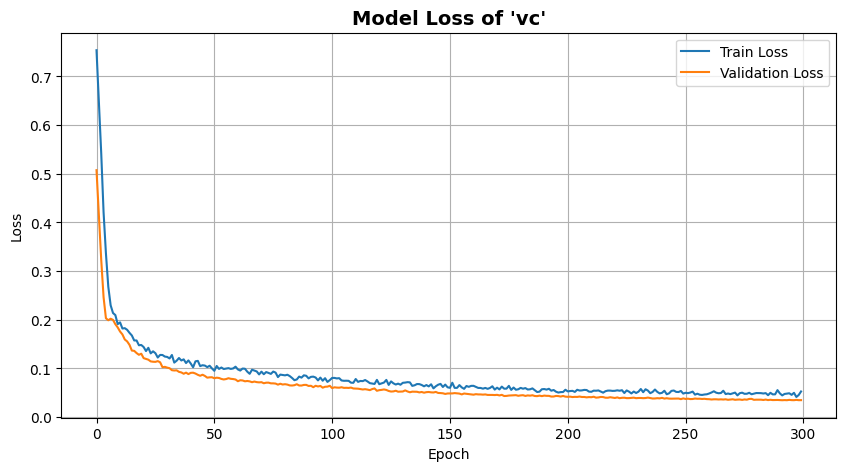

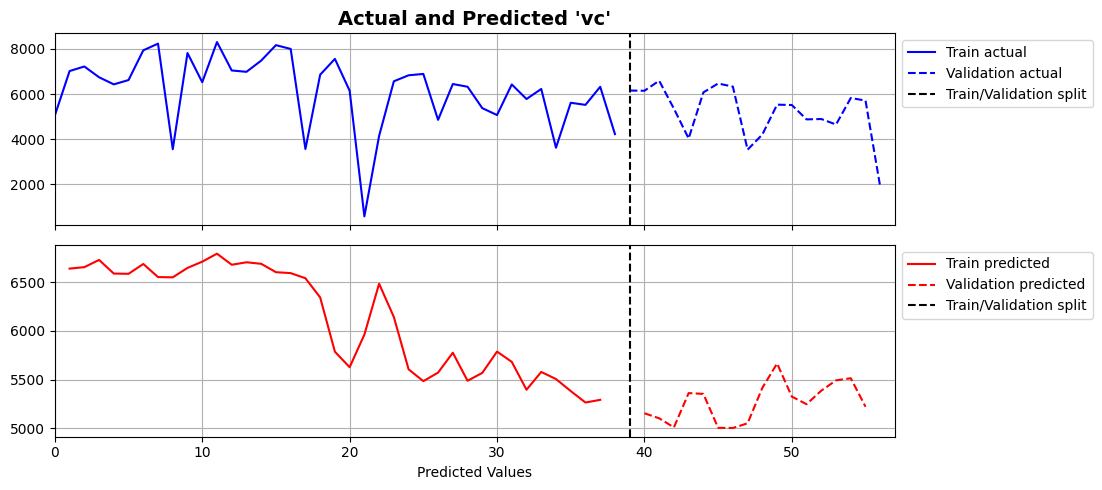

In [23]:
# Plot RMSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

title_text = f"Model Loss of '{target_column}'"
plt.title(title_text, fontdict={'fontsize': 14, 'fontweight': 'bold'}, loc='center')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot Outcomes
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)  # sharex=True ensures that both subplots share the same x-axis

# Actual values
axes[0].plot(np.arange(len(train_target)), train_target.values, 'b-', label='Train actual')
axes[0].plot(np.arange(len(train_target), len(target)), val_target.values, 'b--', label='Validation actual')
axes[0].axvline(x=len(train_target), color='k', linestyle='--', label='Train/Validation split')

title_text = f"Actual and Predicted '{target_column}'"
axes[0].set_title(title_text, fontdict={'fontsize': 14, 'fontweight': 'bold'}, loc='center')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[0].grid(True)

# Predicted values
train_pred_plot_length = np.arange(look_back, look_back + len(train_predictions))
val_pred_plot_length = np.arange(len(train_target) + look_back, len(train_target) + look_back + len(val_predictions))
axes[1].plot(train_pred_plot_length, train_predictions, 'r-', label='Train predicted')
axes[1].plot(val_pred_plot_length, val_predictions, 'r--', label='Validation predicted')
axes[1].axvline(x=len(train_target), color='k', linestyle='--', label='Train/Validation split')

axes[1].set_xlabel('Predicted Values')

axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].grid(True)

# Set the same x-axis limits for both subplots
axes[0].set_xlim(0, len(target))
axes[1].set_xlim(0, len(target))

fig.tight_layout()
fig.subplots_adjust(right=0.75)

plt.show()
